# Vehicle Detection and Tracking Project
The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected

## Project: Vehicle Detection Q&A

https://www.youtube.com/watch?v=P2zwrTM8ueA&feature=youtu.be

In [203]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVR, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle

% matplotlib inline

In [2]:
# Import Images

# Images used for training Linear SVM to recognise cars/not-cars
# Images are divided into vehicle and non-vehicle directories
# All training images are .png
# Vehicle images separated into different folders based on source of the image



# Read in vehicle images
basedir = 'vehicles/'
image_types = os.listdir(basedir) # ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
cars = []

for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+"/*"))
    
print("Number of Vehicle images found: ", len(cars))
with open("cars.txt", "w") as f:
    for fn in cars:
        f.write(fn+"\n")


# Read in non-vehicle images
basedir = "non-vehicles/"
image_types = os.listdir(basedir)
notcars = []

for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+"/*"))
    
print("Number of Non-Vehicle images found: ", len(notcars))
with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+"\n")
        

Number of Vehicle images found:  8792
Number of Non-Vehicle images found:  8968


In [3]:
# Extract HOG Features

In [4]:
# Train Classifer
# Normalise features (StandardScaler)

In [5]:
# Class Code

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:

# Define a function to compute binned color features  

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
"""
# Replace above (from QA video)
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
"""

'\n# Replace above (from QA video)\ndef bin_spatial(img, size=(32,32)):\n    color1 = cv2.resize(img[:,:,0], size).ravel()\n    color2 = cv2.resize(img[:,:,1], size).ravel()\n    color3 = cv2.resize(img[:,:,2], size).ravel()\n    return np.hstack((color1, color2, color3))\n'

In [8]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32): #, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) #, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) #, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) #, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_old(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    




In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [11]:

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [14]:
def single_img_features_vis(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [15]:

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [16]:
# Helper image plotting visualisation function
# From Project Q&A Video

# Define a function for plotting mutliple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap="hot")
            plt.title(titles[i])
        else: 
            plt.imshow(img)
            plt.title(titles[i])

In [17]:
# Single image HOG feature experiments

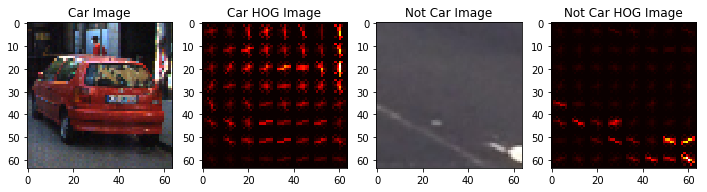

In [18]:
# Choose random car and not car images

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = "YCrCb"     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9              # Number of gradient orientations
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0         # Can be 0, 1, 2, "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64          # Number of histogram bins
spatial_feat = True     # Spatial features on or off
hist_feat = True        # Histogram features on or off
hog_feat = True         # HOG features on or off
vis=True

car_features, car_hog_image = single_img_features_vis(car_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, vis=vis)


notcar_features, notcar_hog_image = single_img_features_vis(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, vis=vis)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["Car Image", "Car HOG Image", "Not Car Image", "Not Car HOG Image"]
fig = plt.figure(figsize=(12, 3))
visualize(fig, 1, 4, images, titles)



## Train Classifier

In [230]:
# Define feature parameters
color_space = "YCrCb"     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9              # Number of gradient orientations
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"         # Can be 0, 1, 2, "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16          # Number of histogram bins
spatial_feat = True     # Spatial features on or off
hist_feat = True        # Histogram features on or off
hog_feat = True         # HOG features on or off


# If experimenting use the testing flag, to only use a sample (reduce training time)
testing = True

print("Started...")

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

if testing == True:
    
    train_cars = np.array(cars)[random_idxs]
    train_notcars = np.array(notcars)[random_idxs]
    print("Experiment running on ", len(train_cars), " examples")
    
else:
    
    train_cars = cars 
    train_notcars = notcars 
    print("Training full model on all " , len(train_cars) + len(train_notcars), " examples")



car_features = extract_features(train_cars, color_space=color_space, spatial_size=spatial_size, 
                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(train_notcars, color_space=color_space, spatial_size=spatial_size, 
                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                  cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


print("Time to compute features: ", round(time.time()-t, 2), "seconds\n")

# Stack Features
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split the data into randomised training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print("Using: \n", orient, " Orientations\n", pix_per_cell, " Pixels per cell\n", 
     cell_per_block, " Cells per block\n", hist_bins, " Histogram bins\n", 
     spatial_size, " Spatial sampling")

print("\nFeature vector length: ", len(X_train[0]))


# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

print("\n\nTraining Linear Support Vector Machine...\n")

# Train a Linear SVC
#svc = SVC(C=100)

svc = LinearSVC(C=1000)

# Check training time for the SVC
t = time.time()
svc.fit(X_train, y_train)

print("Time to train Linear SVC:  ", round(time.time() - t, 2), " seconds")


print("SVM Paramaters: ", svc.get_params())


# Check score of SVC
print("Test Accuracy of Linear SVC: ", round(svc.score(X_test, y_test), 4))
    


Started...
Experiment running on  1000  examples
Time to compute features:  33.88 seconds

Using: 
 9  Orientations
 8  Pixels per cell
 2  Cells per block
 16  Histogram bins
 (16, 16)  Spatial sampling

Feature vector length:  6108


Training Linear Support Vector Machine...

Time to train Linear SVC:   2.25  seconds
SVM Paramaters:  {'loss': 'squared_hinge', 'random_state': None, 'dual': True, 'intercept_scaling': 1, 'C': 1000, 'fit_intercept': True, 'tol': 0.0001, 'multi_class': 'ovr', 'penalty': 'l2', 'class_weight': None, 'verbose': 0, 'max_iter': 1000}
Test Accuracy of Linear SVC:  0.97


(17760, 8460)


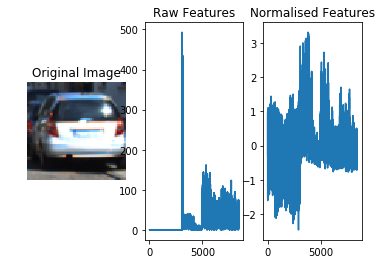

In [196]:
# TODO: show difference between raw and normalised features

rand_int = np.random.randint(0, len(train_cars))
car_image = mpimg.imread(train_cars[rand_int])


# Visualise Raw and Normalised Features
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.figure(figsize=(12,6))

ax1.axis("off")
ax1.imshow(car_image)
ax1.set_title("Original Image")
ax2.plot(X_train[rand_int, :])
ax2.set_title("Raw Features")
ax3.plot(scaled_X_train[rand_int, :])
ax3.set_title("Normalised Features")
plt.subplots_adjust(left=0.1, right=1, top=0.1, bottom=0)


## Saving the trained model

In [244]:
# save the model to disk
filename = 'models/trained_svc5.sav'
pickle.dump(svc, open(filename, 'wb'))


In [188]:
# load the model from disk
filename = 'models/trained_svc.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(round(result, 4))

0.9769


In [183]:
# Assign loaded model for testing
svc = loaded_model

## Testing Images

In [215]:
test_image_path = "test_images/*"
test_images = glob.glob(test_image_path)

print(test_images)

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


Searching:  26  windows
Time taken:  0.3865230083465576  seconds
Searching:  26  windows
Time taken:  0.3473949432373047  seconds
Searching:  26  windows
Time taken:  0.4010028839111328  seconds
Searching:  26  windows
Time taken:  0.4292488098144531  seconds
Searching:  26  windows
Time taken:  0.3821749687194824  seconds
Searching:  26  windows
Time taken:  0.43062710762023926  seconds


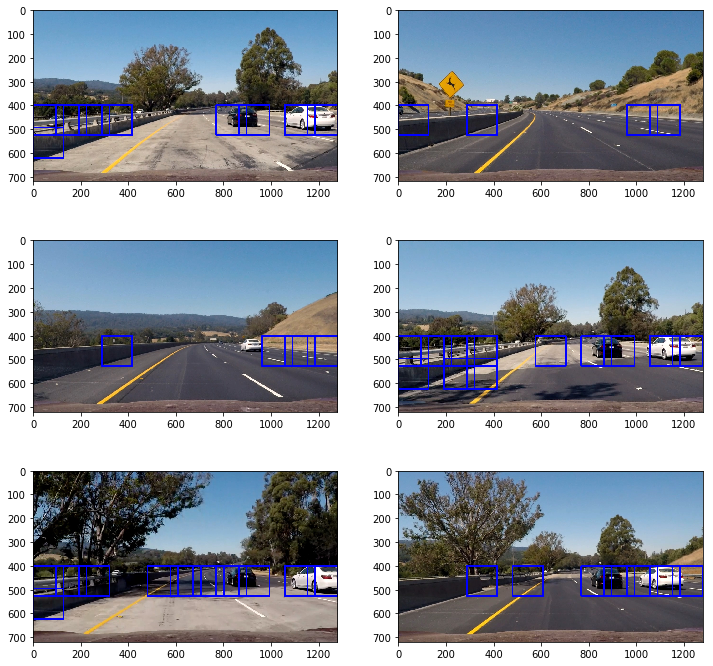

In [219]:

# Test on single images
# Sliding windows and window search

# For Visualisation
images = []
titles = []


# Make sure all parameters are the same as during training or else scalar wont work

color_space = "YCrCb"     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9              # Number of gradient orientations
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"         # Can be 0, 1, 2, "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64          # Number of histogram bins
spatial_feat = True     # Spatial features on or off
hist_feat = True        # Histogram features on or off
hog_feat = True         # HOG features on or off



window_size = 128
overlap = 0.25
ystart = 400
ystop = 625


for image_path in test_images:
    
    t1 = time.time()
    image = mpimg.imread(image_path)
    draw_image = np.copy(image)
    
    # Rescale .jpg image
    image = image.astype(np.float32)/255
    #print(np.min(image), np.max(image))
    

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(window_size, window_size), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    
    images.append(window_image)
    titles.append("")
    
    print("Searching: ", len(windows), " windows")
    print("Time taken: ", time.time() - t1, " seconds")

fig = plt.figure(figsize=(12, 12))
visualize(fig, 3, 2, images, titles)



In [23]:
# Helper function

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [231]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    new_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    
    # Create car bounding boxes and heatmap image
    b_boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                b_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    

    
    return draw_img, b_boxes


In [221]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

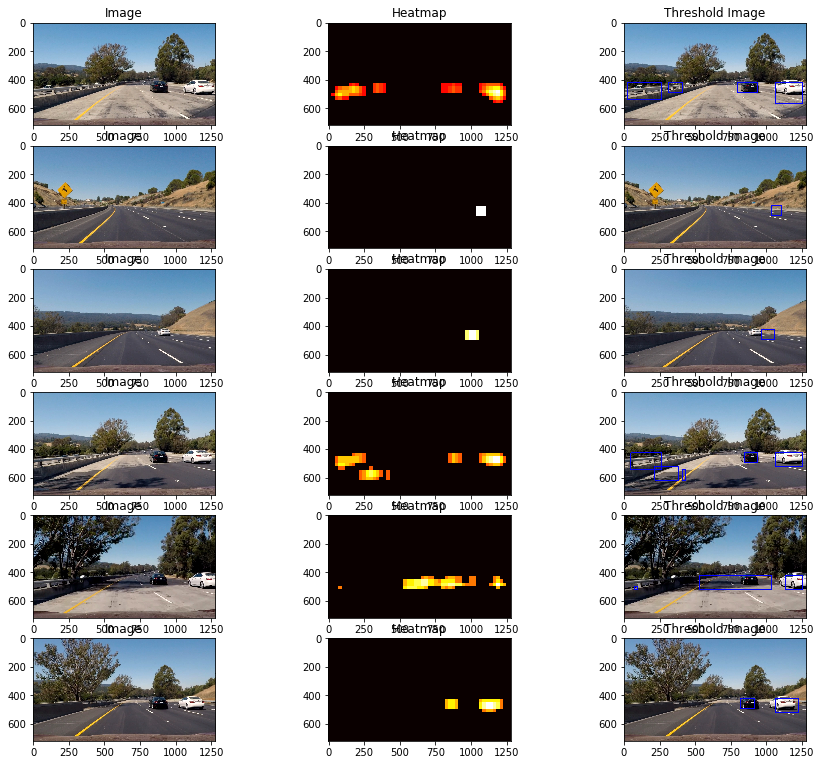

In [232]:
# For visualisation
images = []
titles = []


ystart = 400
ystop = 656
scale = 1.5

for image_path in test_images:
    
    image = mpimg.imread(image_path)    
    new_img = np.copy(image)
    # Rescale .jpg image (done inside find cars)
    # image = image.astype(np.float32)/255    
    
    out_img, b_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    # Heatmap
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    
    # Apply heatmap
    heatmap = add_heat(heatmap, b_boxes)
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap,5)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    new_img = draw_labeled_bboxes(new_img, labels)
    
    images.append(image)
    titles.append("Image")
    images.append(heatmap)
    titles.append("Heatmap")
    images.append(new_img)
    titles.append("Threshold Image")

    
    
    
    
fig = plt.figure(figsize=(15, 20))
visualize(fig, 9, 3, images, titles)



## Full Vehicle Detection Pipeline

In [240]:
def process_image(image):
    
    new_img = np.copy(image)
    
    
    ystart = 400
    ystop = 656
    scale = 1.5
    
    out_img, b_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    

    # Apply heatmap
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, b_boxes)
    
    
    # Start with high threshold until able to smooth using multiple frames
    heat_threshold = 20
    heatmaps.append(heatmap)

    
    # False positive detection
    # If multiple heatmaps, average over the last 5
    if len(heatmaps) > 10:
        
        heatmap = np.mean(heatmaps[-5:], axis=0)
        heat_threshold = 7
    
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, heat_threshold)
    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    new_img = draw_labeled_bboxes(new_img, labels)
    
    
    return new_img
    

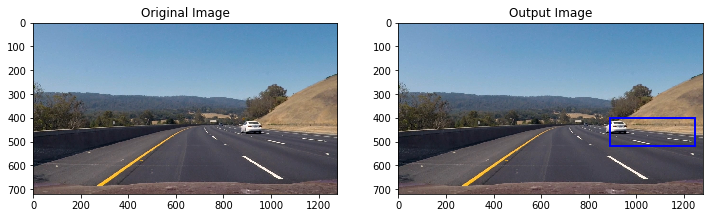

In [237]:
heatmaps = []


# Test Images
test_image_path = "test_images/*"
test_images = glob.glob(test_image_path)

rand_int = np.random.randint(0, len(test_images))

test_image = mpimg.imread(test_images[rand_int])

test_output = process_image(test_image)

images = [test_image, test_output]
titles = ["Original Image", "Output Image"]


fig = plt.figure(figsize=(12, 6))
visualize(fig, 1, 2, images, titles)



## Video Processing

In [146]:
# Import everything needed to edit/save/watch video clips# Import 

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [243]:


heatmaps = []


# Video processing and output (from introduction project)

video_output = 'output_videos/project_video_outputx3.mp4'

#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(0,20)
#clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video output_videos/project_video_outputx3.mp4
[MoviePy] Writing video output_videos/project_video_outputx3.mp4



 31%|███       | 155/501 [02:14<04:59,  1.16it/s]


 62%|██████▏   | 309/501 [04:27<02:41,  1.19it/s]


 92%|█████████▏| 463/501 [06:38<00:31,  1.19it/s]


100%|█████████▉| 500/501 [07:09<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_outputx3.mp4 

CPU times: user 6min 26s, sys: 27.7 s, total: 6min 54s
Wall time: 7min 11s
